# Libraries

In [1]:
import torch
import torch.nn as nn

# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda") 
    print("GPU is available. Using:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu") 
    print("GPU not available, using CPU.")


GPU is available. Using: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
from math import ceil
import numpy as np
import torchaudio
from scipy import signal
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from collections import Counter
from scipy.io import wavfile
from imblearn.over_sampling import SMOTE
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, precision_recall_curve, roc_curve, roc_auc_score, ConfusionMatrixDisplay

# Data Loader and Visualization

In [3]:
healthy_files = glob.glob(os.path.join("dataset", "Normal", "*"))
laryngocele_files = glob.glob(os.path.join("dataset", "laryngozele", "*"))
vox_senilis_files = glob.glob(os.path.join("dataset", "Vox senilis", "*"))

In [4]:
print(f"\nTotal Normal files: {len(healthy_files)}")
print(f"\nTotal Laryngozele files: {len(laryngocele_files)}")
print(f"\nTotal Vox_senilis files: {len(vox_senilis_files)}")


Total Normal files: 1120

Total Laryngozele files: 168

Total Vox_senilis files: 784


# Audio Analysis

In [5]:
sound, sample_rate = torchaudio.load(healthy_files[1])
ipd.Audio(data=sound[0,:],rate=sample_rate) 

In [6]:
sound, sample_rate = torchaudio.load(laryngocele_files[3])
ipd.Audio(data=sound[0,:],rate=sample_rate) 

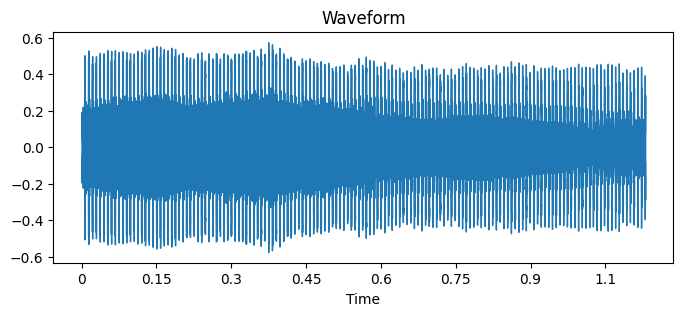

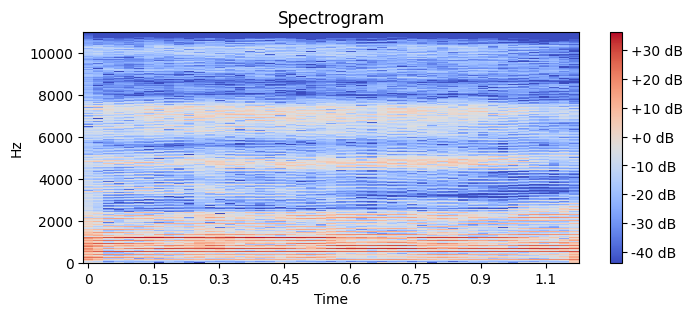

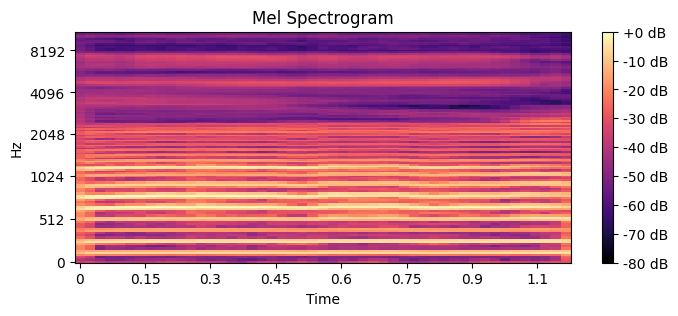

In [7]:
x, sr = librosa.load(laryngocele_files[2])

# Plot the waveform
plt.figure(figsize=(8, 3))
librosa.display.waveshow(y=x, sr=sr)
plt.title("Waveform")
plt.show()

# Compute the Short-Time Fourier Transform (STFT)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))

# Plot the spectrogram
plt.figure(figsize=(8, 3))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram")
plt.show()

# Compute the Mel spectrogram
S = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

# Plot the Mel spectrogram
plt.figure(figsize=(8, 3))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.show()


# Feature Extraction

In [8]:
def extract_mfcc(file_path, n_mfcc=13, max_len=500):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    # Pad or truncate MFCC to max_len
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), 'constant')
    else:
        mfcc = mfcc[:, :max_len]  # Truncate
    return mfcc.T  # Return shape: (max_len, n_mfcc)

In [9]:
# Set maximum length for padding
max_len = 500 

In [10]:
laryngocele_features = [extract_mfcc(file, max_len=max_len) for file in laryngocele_files]
vox_senilis_features = [extract_mfcc(file, max_len=max_len) for file in vox_senilis_files]
healthy_features = [extract_mfcc(file, max_len=max_len) for file in healthy_files]

In [11]:
X_laryngocele = np.array([mfcc.flatten() for mfcc in laryngocele_features])  # Diseased: Laryngocele
X_vox_senilis = np.array([mfcc.flatten() for mfcc in vox_senilis_features])  # Diseased: Vox Senilis
X_healthy = np.array([mfcc.flatten() for mfcc in healthy_features])  # Healthy samples

# Create labels
y_laryngocele = np.ones(X_laryngocele.shape[0])  # Class 1: Diseased
y_vox_senilis = np.ones(X_vox_senilis.shape[0])  # Class 1: Diseased
y_healthy = np.zeros(X_healthy.shape[0])         # Class 0: Normal

# Combine features and labels into a single dataset
X_diseased = np.vstack((X_laryngocele, X_vox_senilis))  # Combine laryngocele and vox senilis
y_diseased = np.hstack((y_laryngocele, y_vox_senilis))

In [12]:
X = np.vstack((X_diseased, X_healthy))  # Combine diseased and healthy features
y = np.hstack((y_diseased, y_healthy))

In [13]:
smote = SMOTE(sampling_strategy='auto', random_state=42)  # Upsample to match class sizes
X_resampled, y_resampled = smote.fit_resample(X, y)

In [14]:
print("Resampled X size:", X_resampled.shape)
print("Resampled y size:", y_resampled.shape)

# Check class distribution
print("Original class distribution:", Counter(y))
print("Resampled class distribution:", Counter(y_resampled))

Resampled X size: (2240, 6500)
Resampled y size: (2240,)
Original class distribution: Counter({0.0: 1120, 1.0: 952})
Resampled class distribution: Counter({1.0: 1120, 0.0: 1120})


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device) 
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Classification (Diseased or Healthy)

In [16]:
from oselm import OSELM

In [17]:
hidden_num = 800
n_input_nodes = X_train.shape[1]  # Number of features after flattening
n_output_nodes = 2  # Number of classes for binary classification

In [18]:
elm = OSELM(n_input_nodes, hidden_num, n_output_nodes, device)

In [19]:
# Early stopping parameters
patience = 2
best_test_accuracy = 0
epochs_without_improvement = 0

In [20]:
for epoch in range(5):  # Specify the number of epochs
    print(f"Epoch {epoch + 1}:")
    
    elm.train()  # Set the model to training mode
    for i in range(0, len(X_train_tensor), 1000):
        train_x = X_train_tensor[i:i + 1000]
        train_y = nn.functional.one_hot(y_train_tensor[i:i + 1000], num_classes=n_output_nodes).float()  # One-hot encoding
        
        # Train the model
        elm.train_model(train_x, train_y)
        
        # Calculate training accuracy after each batch
        train_accuracy, _ = elm.test_model(train_x, train_y)
        print(f"Training accuracy after batch {i // 1000 + 1}: {train_accuracy:.4f}")

    # Testing
    elm.eval()  # Set the model to evaluation mode
    test_accuracy, fx = elm.test_model(X_test_tensor, nn.functional.one_hot(y_test_tensor, num_classes=n_output_nodes).float())
    print(f"Test accuracy after epoch {epoch + 1}: {test_accuracy:.4f}")

    # Early stopping check
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

Epoch 1:
Training accuracy after batch 1: 0.9880
Training accuracy after batch 2: 0.9053
Test accuracy after epoch 1: 0.6629
Epoch 2:
Training accuracy after batch 1: 0.9320
Training accuracy after batch 2: 0.9078
Test accuracy after epoch 2: 0.6629
Epoch 3:
Training accuracy after batch 1: 0.9160
Training accuracy after batch 2: 0.9066
Test accuracy after epoch 3: 0.6629
Early stopping triggered after 3 epochs.


ROC AUC: 0.7321


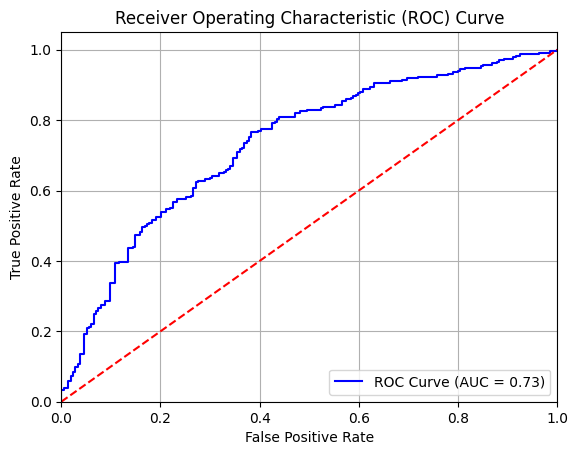

In [21]:
# Calculate ROC AUC
y_pred_prob = torch.softmax(fx, dim=1).cpu().numpy()[:, 1]  # Get probabilities for the positive class
roc_auc = roc_auc_score(y_test_tensor.cpu().numpy(), y_pred_prob)  # Ensure y_test is a NumPy array

print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_tensor.cpu().numpy(), y_pred_prob) 
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

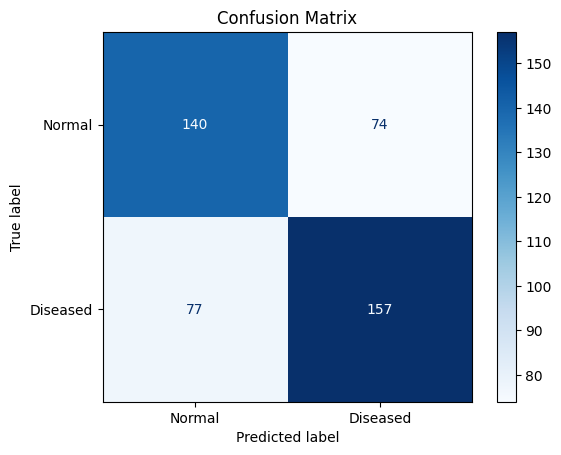

In [22]:
# Confusion Matrix
y_pred = torch.argmax(fx.cpu(), dim=1).numpy()
cm = confusion_matrix(y_test_tensor.cpu().numpy(), y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Diseased'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()